# 0.0 Imports

In [2]:
import math

import pandas as pd
import numpy as np
import inflection

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as ss

from IPython.core.display import HTML
from IPython.display import Image

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv('/home/mvrcosp/repos/DSP/Rossmann/data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/home/mvrcosp/repos/DSP/Rossmann/data/raw/store.csv', low_memory=False)

In [6]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 0.3 Data Dictionary

* **Id** - an Id that represents a (Store, Date) duple within the test set

* **Store** - a unique Id for each store

* **Sales** - the turnover for any given day (this is what you are predicting)

* **Customers** - the number of customers on a given day

* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open

* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b  Easter holiday, c = Christmas, 0 = None

* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools

* **StoreType** - differentiates between 4 different store models: a, b, c, d

* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended

* **CompetitionDistance** - distance in meters to the nearest competitor store

* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

* **Promo** - indicates whether a store is running a promo on that day

* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2

* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 1.0 Data Description

## 1.1 Rename columns

In [9]:
df1 = df_raw.copy()

In [10]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [11]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [12]:
oldcols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_news = list(map(snakecase, oldcols))

df1.columns = cols_news

## 1.2 Data Exploration

In [13]:
#Data dimensions

print("number of rows: {}".format(len(df1)))
print("number of columns: {}".format(df1.shape[1]))

number of rows: 1017209
number of columns: 18


In [14]:
#Data types

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

## 1.3 Dates to datetime

In [15]:
df1['date'] = pd.to_datetime(df1['date'])

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.4 Check and fill NA

In [17]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [18]:
print(df1['competition_distance'].max())
print(df1['competition_open_since_year'].max())

75860.0
2015.0


In [19]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week         
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  

month_map = {1: 'Jan', 2: 'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [20]:
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5 Change dtypes

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.6 Descriptive Statistics

In [24]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Numerical Attributes

In [25]:
#Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).transpose()
ct2 = pd.DataFrame(num_attributes.apply(np.median)).transpose()

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).transpose()
d2 = pd.DataFrame(num_attributes.apply(np.min)).transpose()
d3 = pd.DataFrame(num_attributes.apply(np.max)).transpose()
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).transpose()
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).transpose()
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).transpose()

#concatenate
m = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6]).transpose().reset_index()
m.columns = ['index', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

In [26]:
m

,index,mean,median,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


/home/mvrcosp/repos/DSP/Rossmann/env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

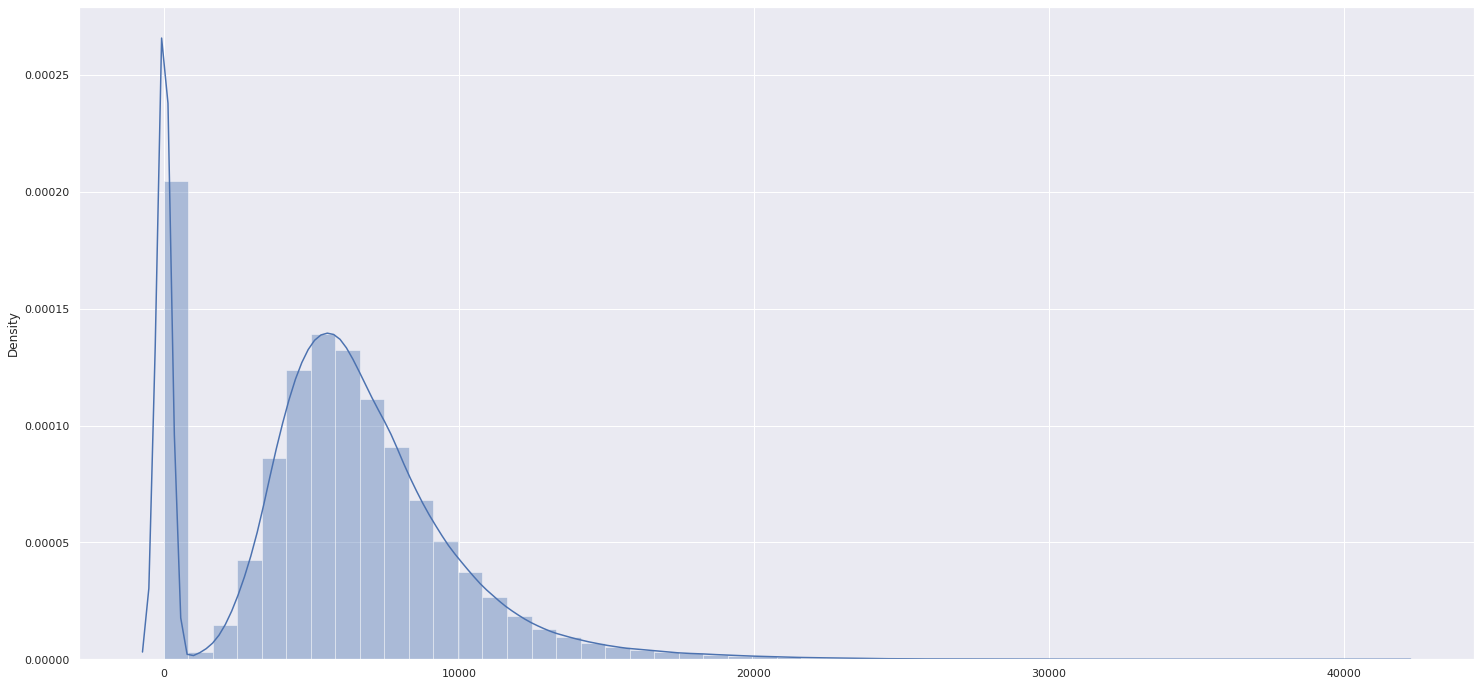

In [27]:
sns.distplot(x=df1['sales'])

### 1.6.2 Categorical attributes

In [28]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

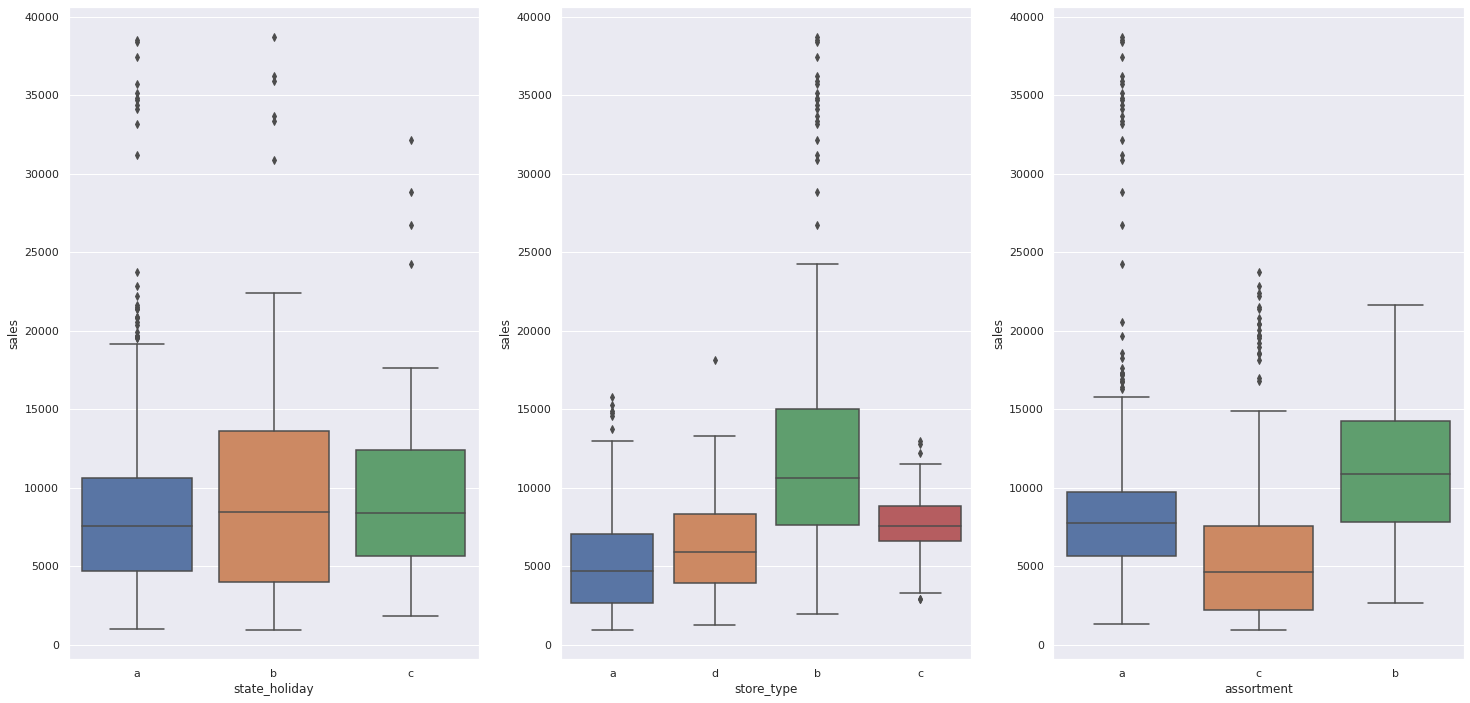

In [29]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Business Hypothesis MindMap

In [30]:
df2 = df1.copy()

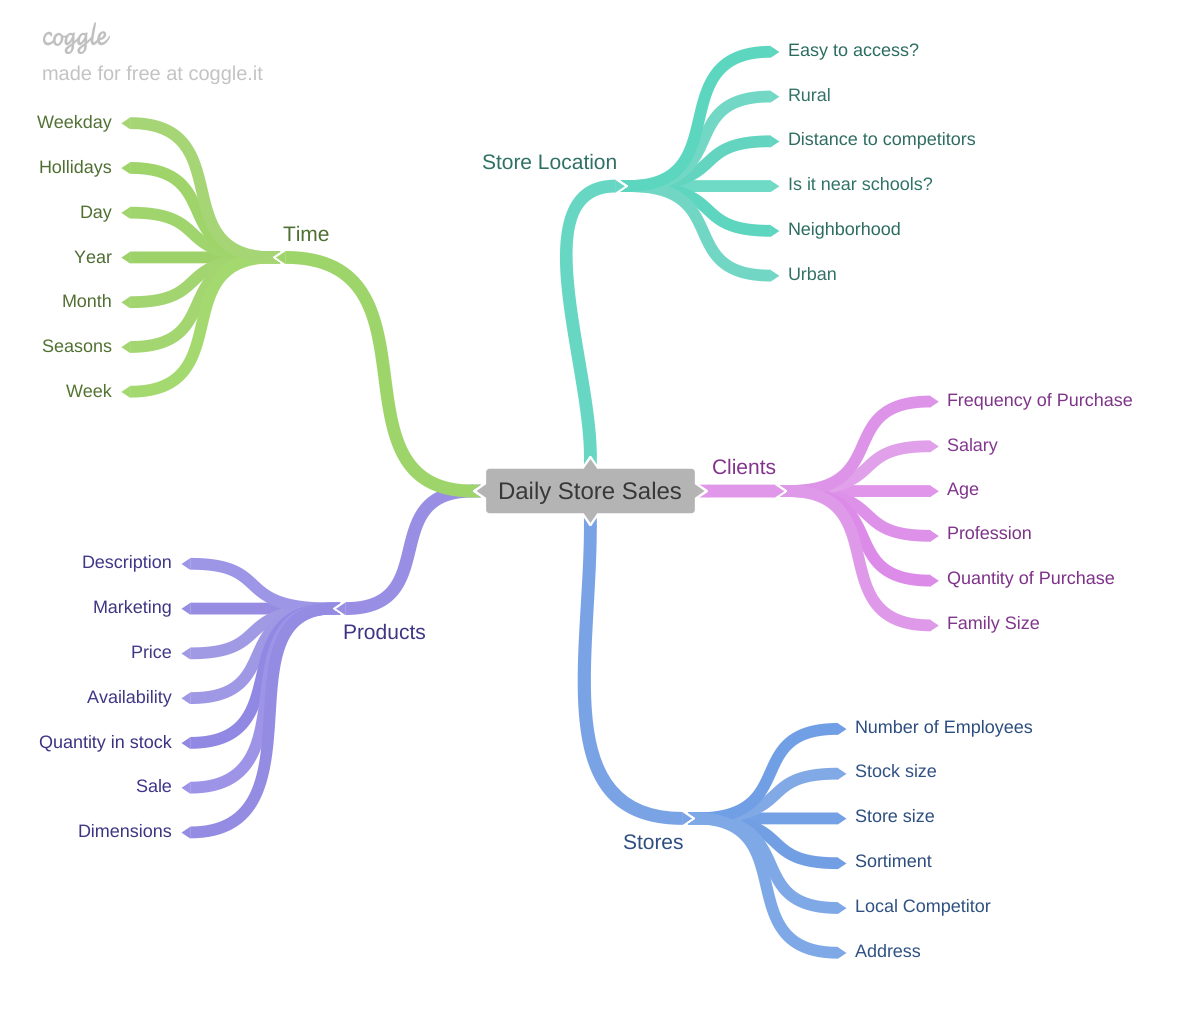

In [31]:
Image("/home/mvrcosp/repos/DSP/Rossmann/img/EngMindMapHypothesis.png")

## 2.1 Brainstorming Business Hypothesis to validate with data!

### 2.1.1 Store Hypothesis

**1.** Stores with a bigger number of employees should sell more.

**2.** Stores with a bigger stock size should sell more.

**3.** Stores with a bigger size should sell more.

**4.** Stores with local competitors should sell less.

**5.** Stores with longer-term competitors should sell more.

**6.** Stores with bigger assortment should sell more.

### 2.1.2 Product Hypothesis

**1.** Stores that invest in marketing strategies should sell more.

**2.** Stores that showcase their product better should sell more.

**3.** Stores with cheaper products should sell more.

**4.** Stores that perform more agressive promos should sell more.

**5.** Stores that keep their promos active for longer periods should sell more.

**6** Stores with consecutive promos should sell more.

### 2.1.3 Sazonality Hypothesis

**1.** Stores that open during christmas season should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more at the 2nd semester of the year.

**4.** Stores should sell more at the beginning of each month.

**5.** Stores should sell more on weekends.

**6.** Stores should sell less on school holidays.

## 2.2 Final Business Hypothesis List

**H1.** Stores with bigger assortment should sell more.

**H2.** Stores with local competitors should sell less.

**H3.** Stores with longer-term competitors should sell more.

**H4.** Stores that keep their promos active for longer periods should sell more.

**H5.** Stores with consecutive promos should sell more.

**H6.** Stores that open during christmas season should sell more.

**H7.** Stores should sell more over the years.

**H8.** Stores should sell more at the 2nd semester of the year.

**H9.** Stores should sell more at the beginning of each month.

**H10.** Stores should sell less on weekends.

**H11.** Stores should sell less on school holidays.

## 2.3 Feature Engineering

In [32]:
df2['date'] = pd.to_datetime(df2['date'])

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

/tmp/ipykernel_214749/1174253869.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 Data Filtering

In [33]:
df3 = df2.copy()

In [34]:
df3 = df3[(df3["open"] != 0) & (df3['sales'] > 0)]

In [35]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3.drop(cols_drop, inplace=True, axis=1)

In [36]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [37]:
df3.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

# 4.0 Exploratory Data Analysis

In [38]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.1.1 Target Variable

/home/mvrcosp/miniconda3/envs/DataScience_Em_Producao/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

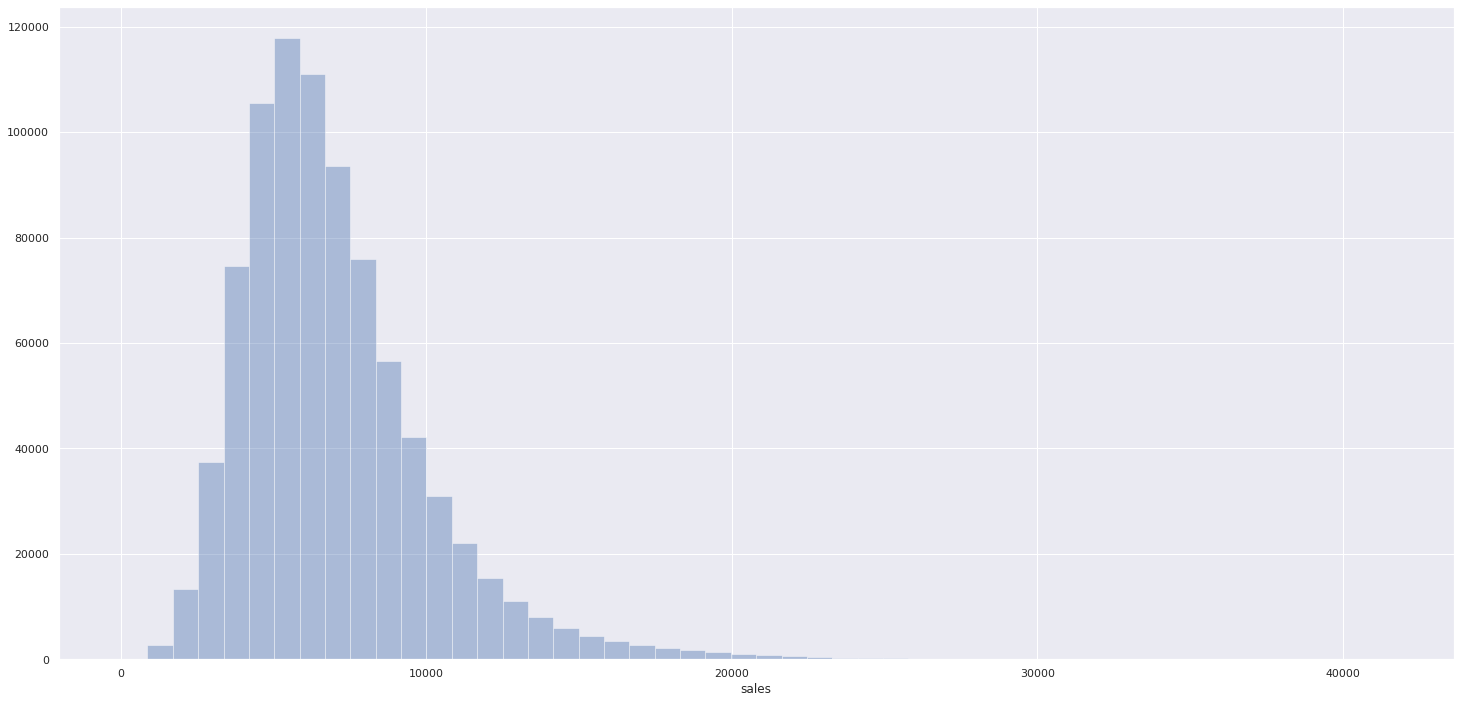

In [38]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2 Numerical Variables

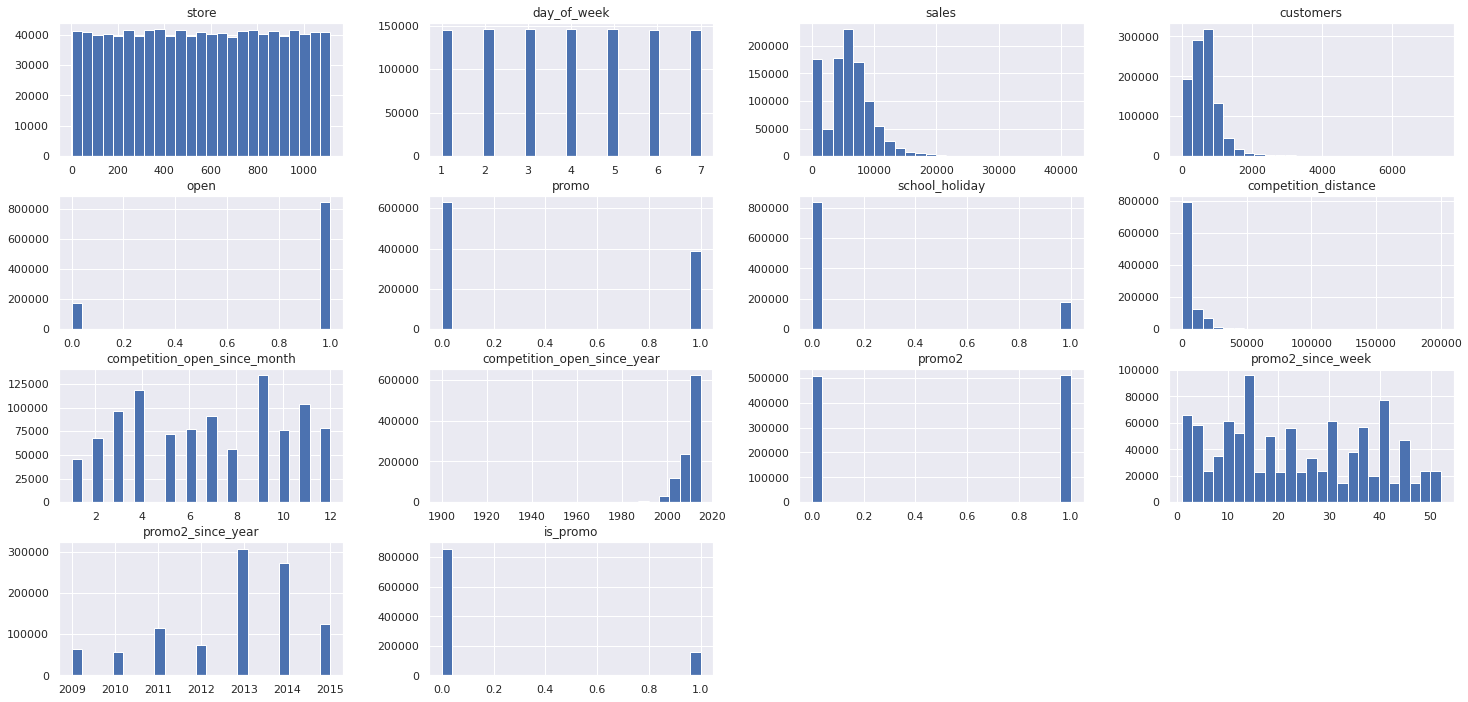

In [39]:
num_attributes.hist(bins=25)
plt.show()

### 4.1.3 Categorical Variables

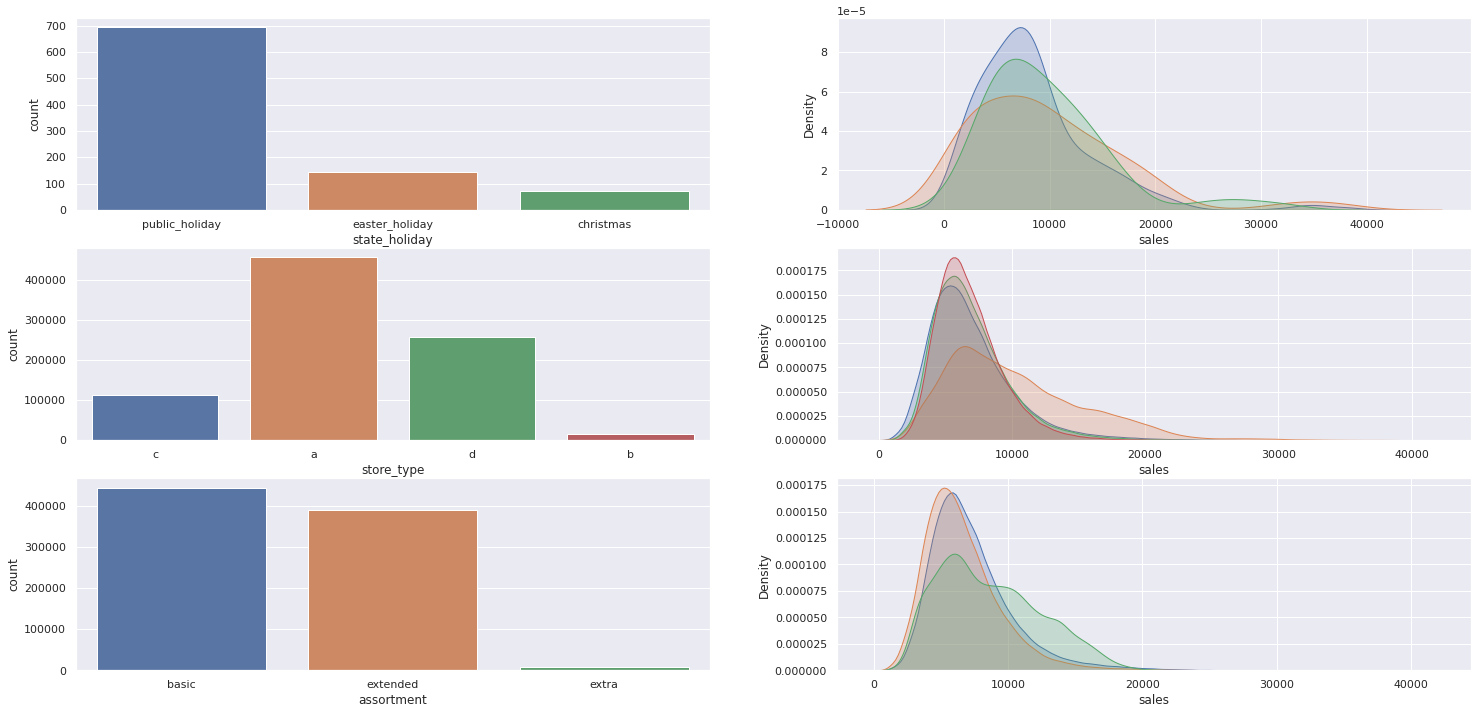

In [40]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x = 'state_holiday', data = a )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot(x = 'store_type', data = df4)

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x = 'assortment', data = df4)

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

plt.show()

## 4.2 Bivariate Analysis - Validating Business Hypothesis

### 4.2.1 - H1 - Stores with extended assortment should sell more.


**True:** In average stores with extended assortment do sell more than stores with basic assortment, although the values are really close. An interesting finding here is that in average the extra category sells the best, but unfortunately we don't have many samples of it in our dataset. 

In [42]:
df4.assortment.value_counts()
df4[df4["assortment"].isin()] 

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

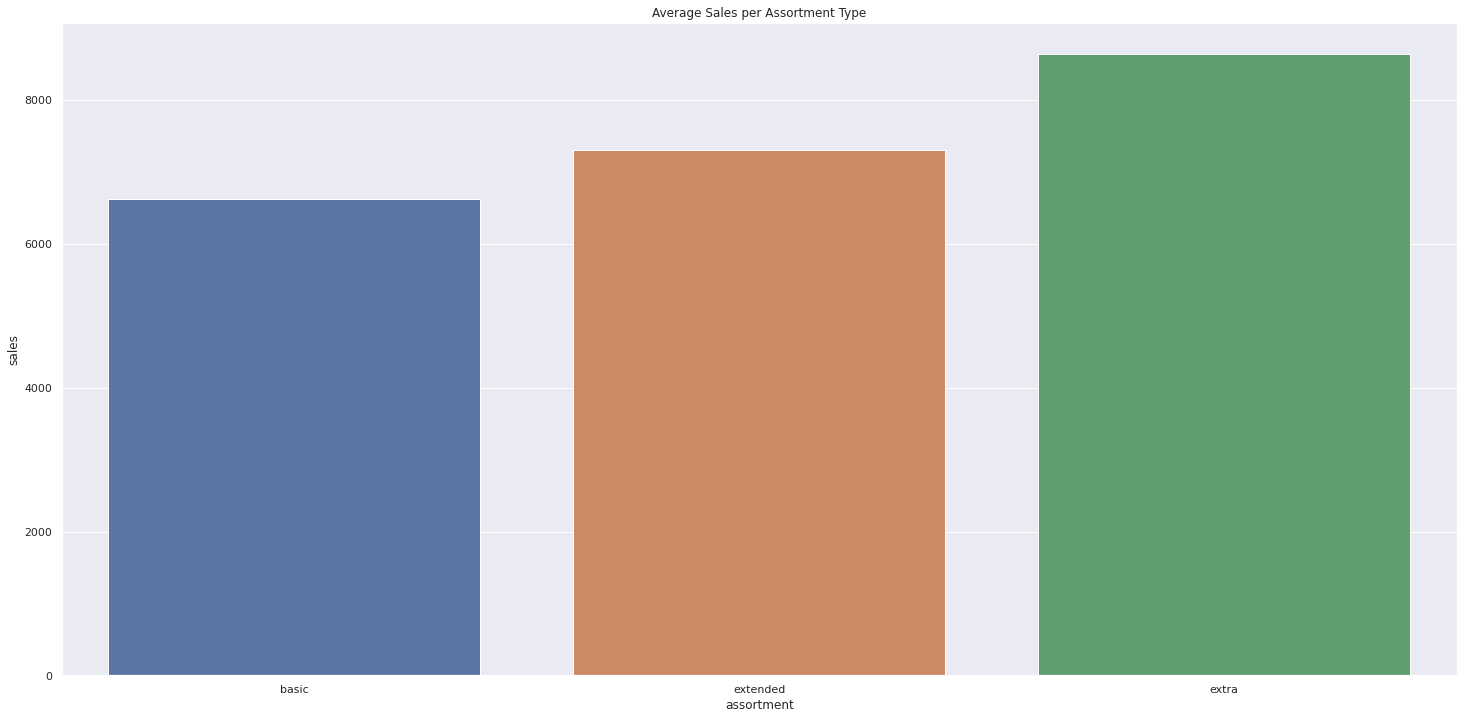

In [47]:
aux421_1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
fig = sns.barplot(x = 'assortment', y ='sales', data = aux421_1).set_title("Average Sales per Assortment Type").get_figure()
fig.savefig("/home/mvrcosp/repos/DSP/Rossmann/img/AverageSalesAssortment.png")

<AxesSubplot:xlabel='year_week'>

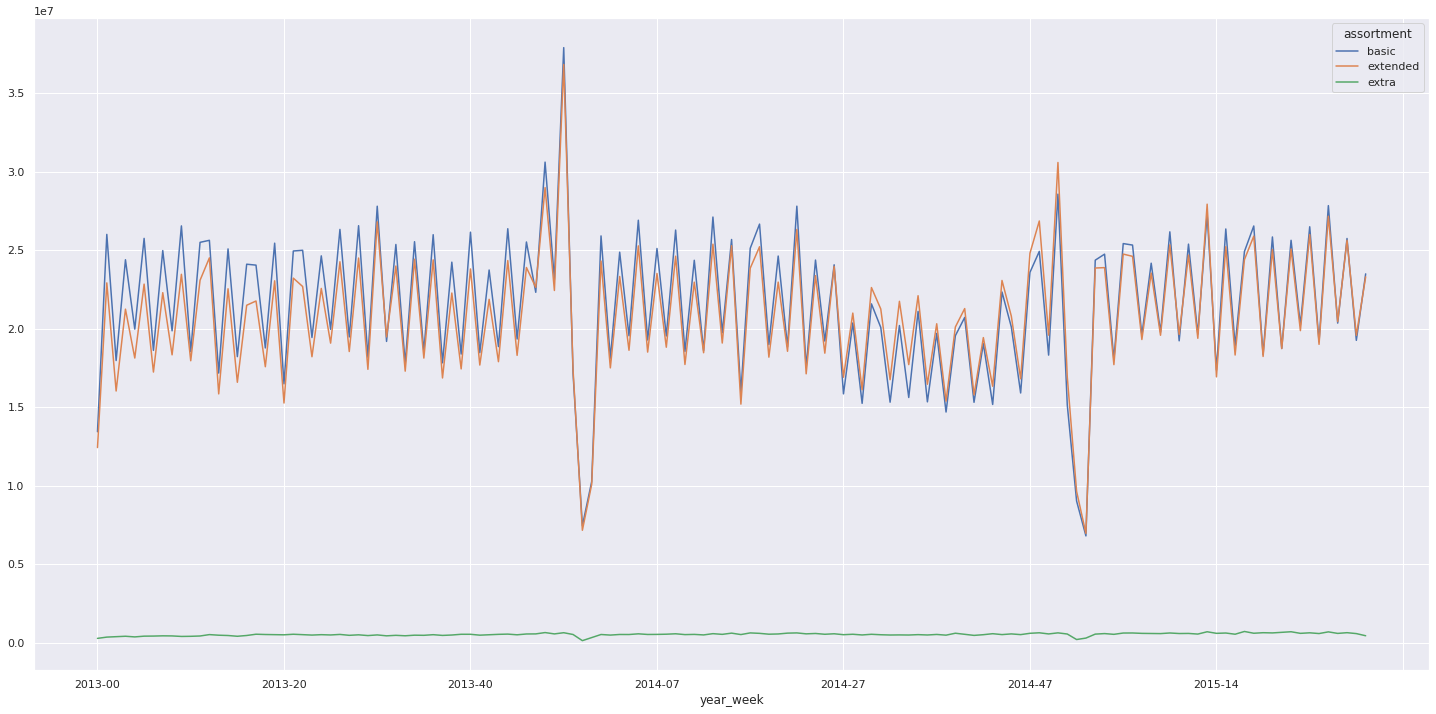

In [42]:
aux421_2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux421_2.pivot(index='year_week', columns='assortment', values='sales').plot()

<AxesSubplot:>

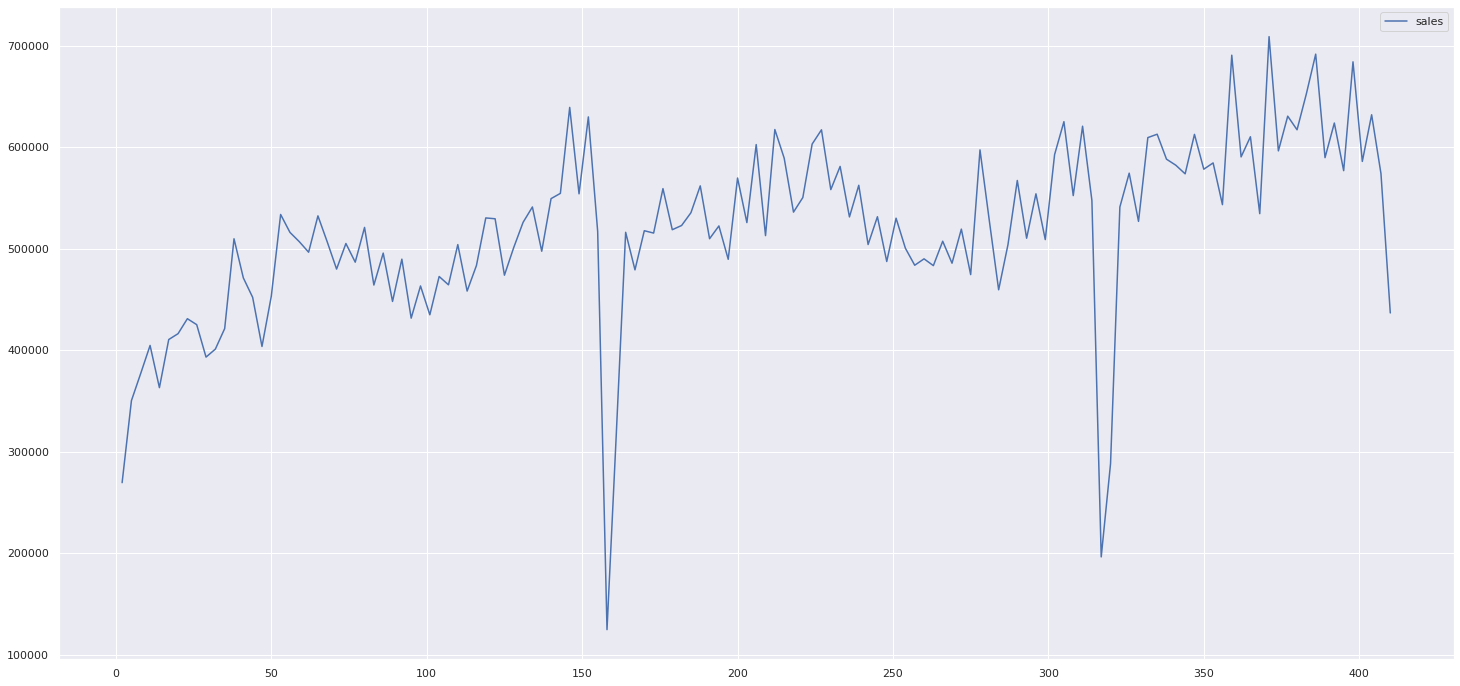

In [43]:
aux421_2[aux421_2['assortment'] =='extra'].plot()

### 4.2.2 - H2 - Stores with local competitors should sell less.
**False:** Stores with competitors close by, in reality, sell more.

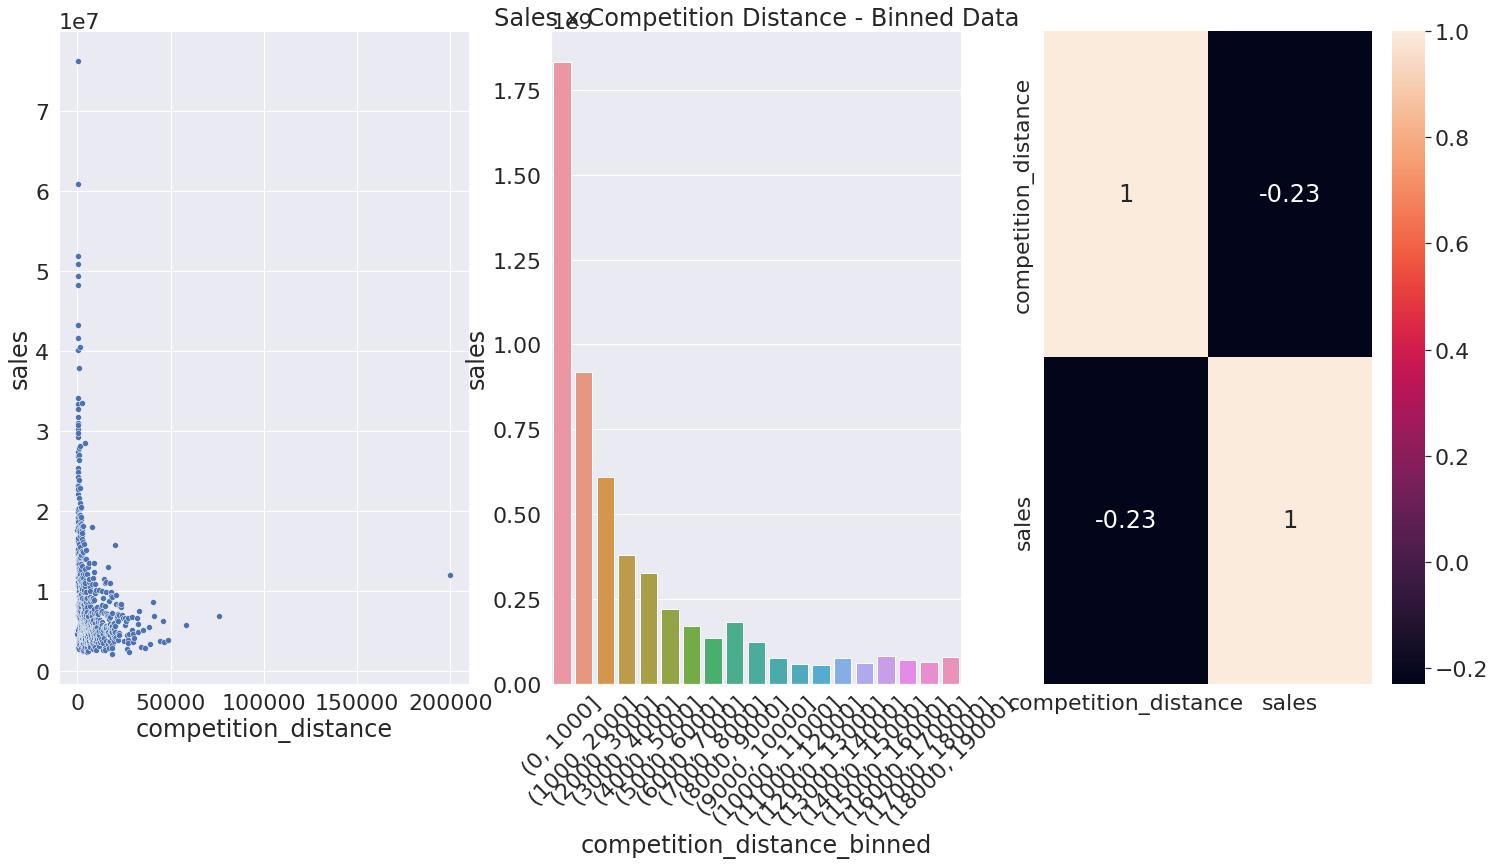

In [49]:
aux422_1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux422_1)


plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux422_1['competition_distance_binned'] = pd.cut(aux422_1['competition_distance'], bins = bins)
aux422_2 = aux422_1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
#sns.set(font_scale=2)
#plt.subplots_adjust(left=0.1, right=0.9, bottom=0.3, top=0.9)
g = sns.barplot(x='competition_distance_binned', y='sales', data=aux422_2).set_title("Sales x Competition Distance - Binned Data").get_figure()
plt.xticks(rotation=45)
#g.savefig("/home/mvrcosp/repos/DSP/Rossmann/img/CompetitionDistanceBinned.png")


plt.subplot(1, 3, 3)
heat = sns.heatmap(aux422_1.corr(method='pearson'), annot=True)

plt.show()

In [68]:
type(g)

matplotlib.figure.Figure

### 4.2.3 - H3 - Stores with longer-term competitors should sell more.
**False:** In reality, stores with longer-term competitiors sell less.

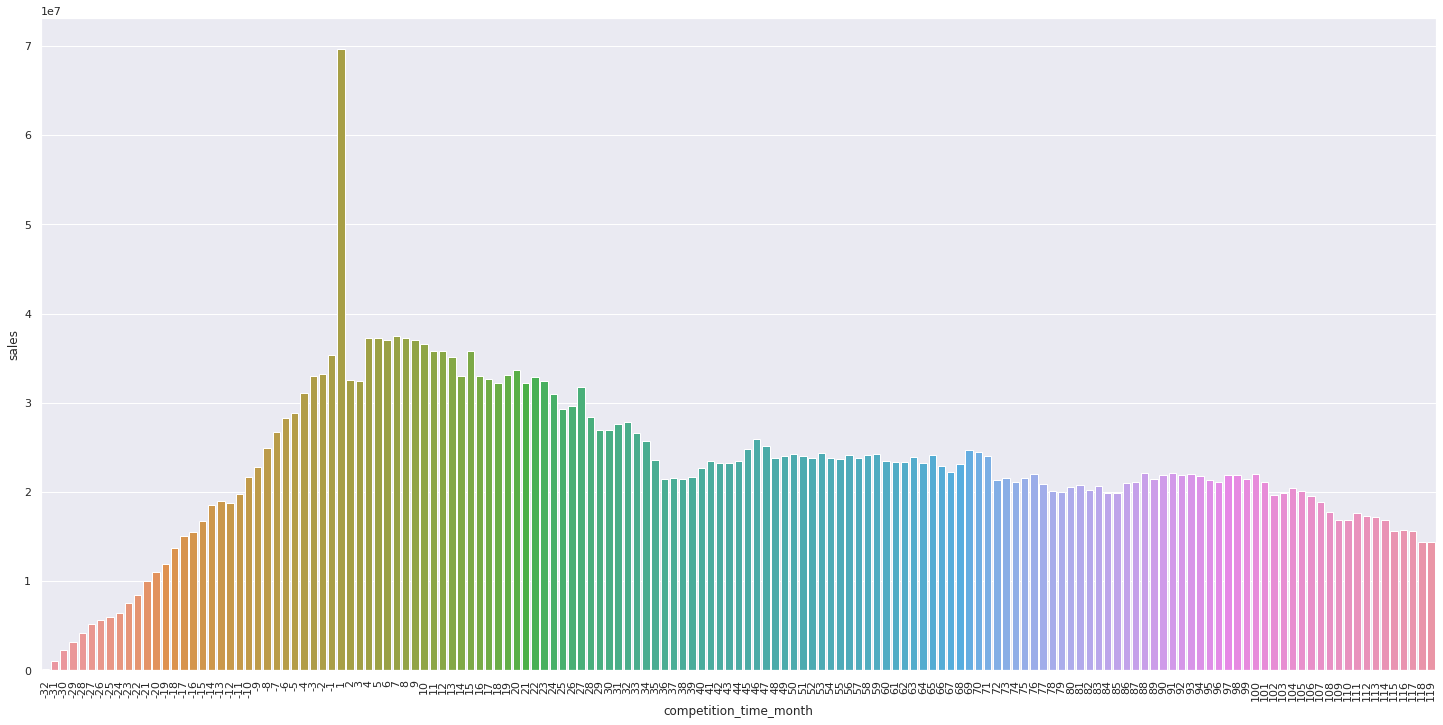

In [45]:
aux423_1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux423_2 = aux423_1[( aux423_1['competition_time_month'] < 120 ) & ( aux423_1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux423_2 );
plt.xticks( rotation=90 );

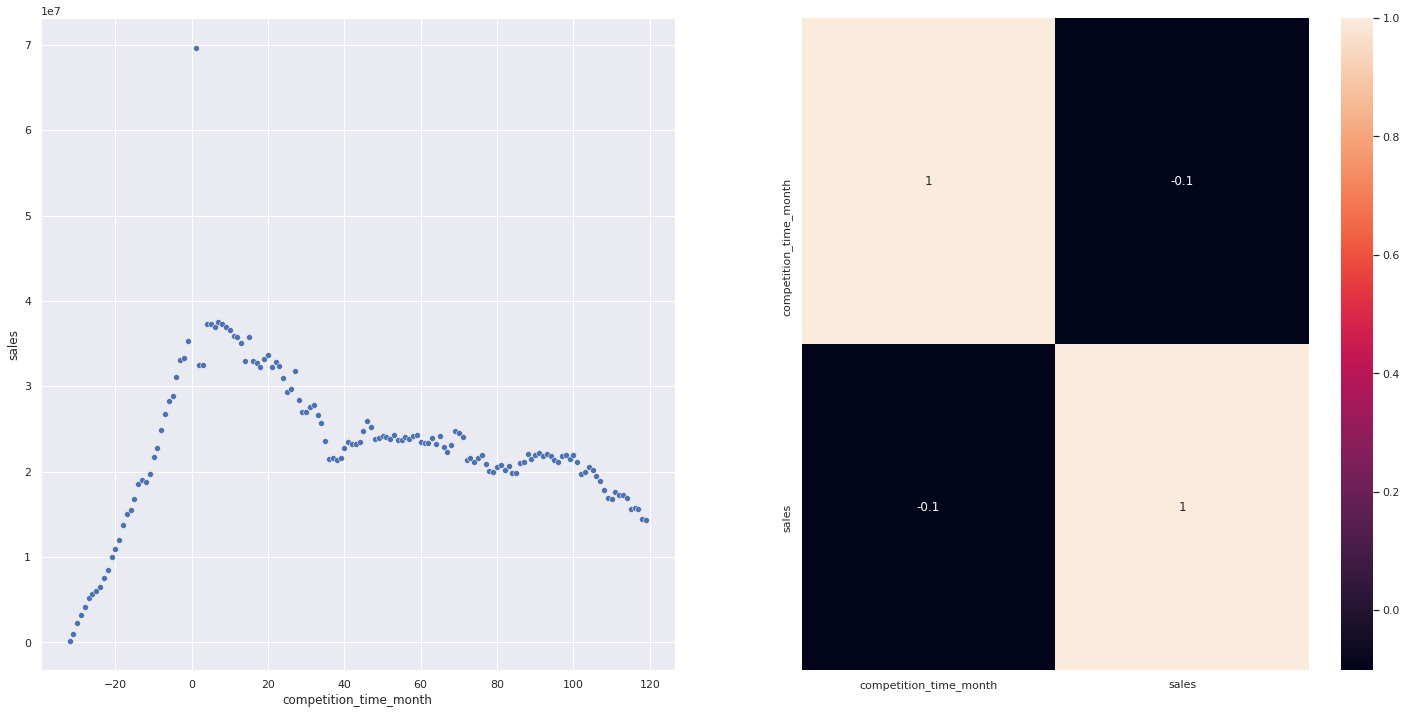

In [46]:
plt.subplot( 1, 2, 1 )
sns.scatterplot( x='competition_time_month', y='sales', data=aux423_2 );

plt.subplot( 1, 2, 2 )
x = sns.heatmap( aux423_1.corr( method='pearson'), annot=True );

### 4.2.4 - H4 - Stores that keep their promos active for longer periods should sell more.

**False:** Actually sales start to drop after a few weeks in promotion.

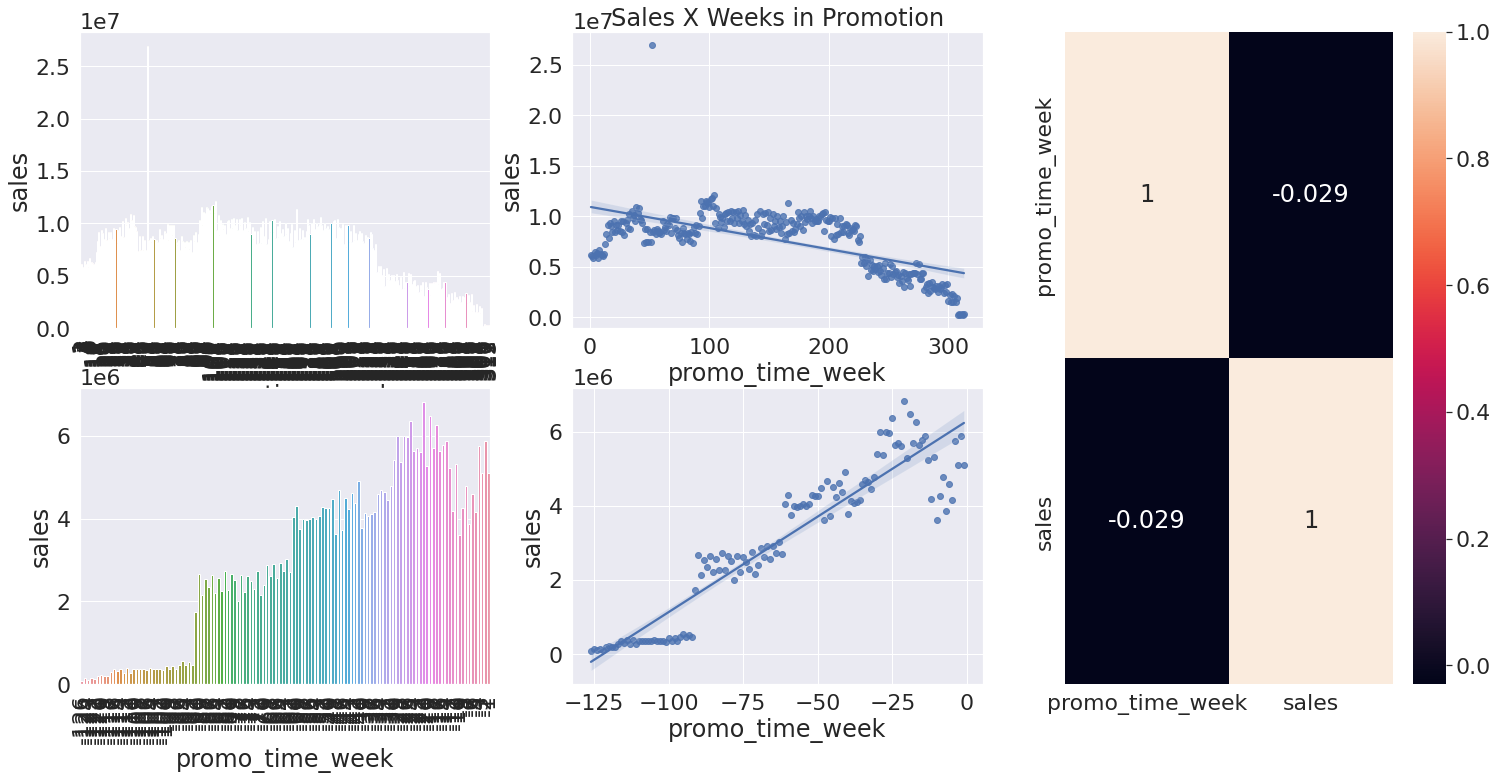

In [55]:
aux424_1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux424_2 = aux424_1[aux424_1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux424_2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
#sns.set(font_scale=2)
#plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
g = sns.regplot( x='promo_time_week', y='sales', data=aux424_2 ).set_title("Sales X Weeks in Promotion").get_figure()
#g.savefig("/home/mvrcosp/repos/DSP/Rossmann/img/SalesOverWeeks.png")

plt.subplot( grid[1,0] )
aux424_3 = aux424_1[aux424_1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux424_3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux424_3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux424_1.corr( method='pearson' ), annot=True );

### 4.2.5 - H5 - Stores with consecutive promos should sell more.

**False:** Stores with consecutive promos actually sell less than stores with only promo 1.

In [48]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [49]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().sort_values(by='sales').reset_index()

,promo,promo2,sales
0,0,1,1289362241
1,1,1,1472275754
2,0,0,1482612096
3,1,0,1628930532


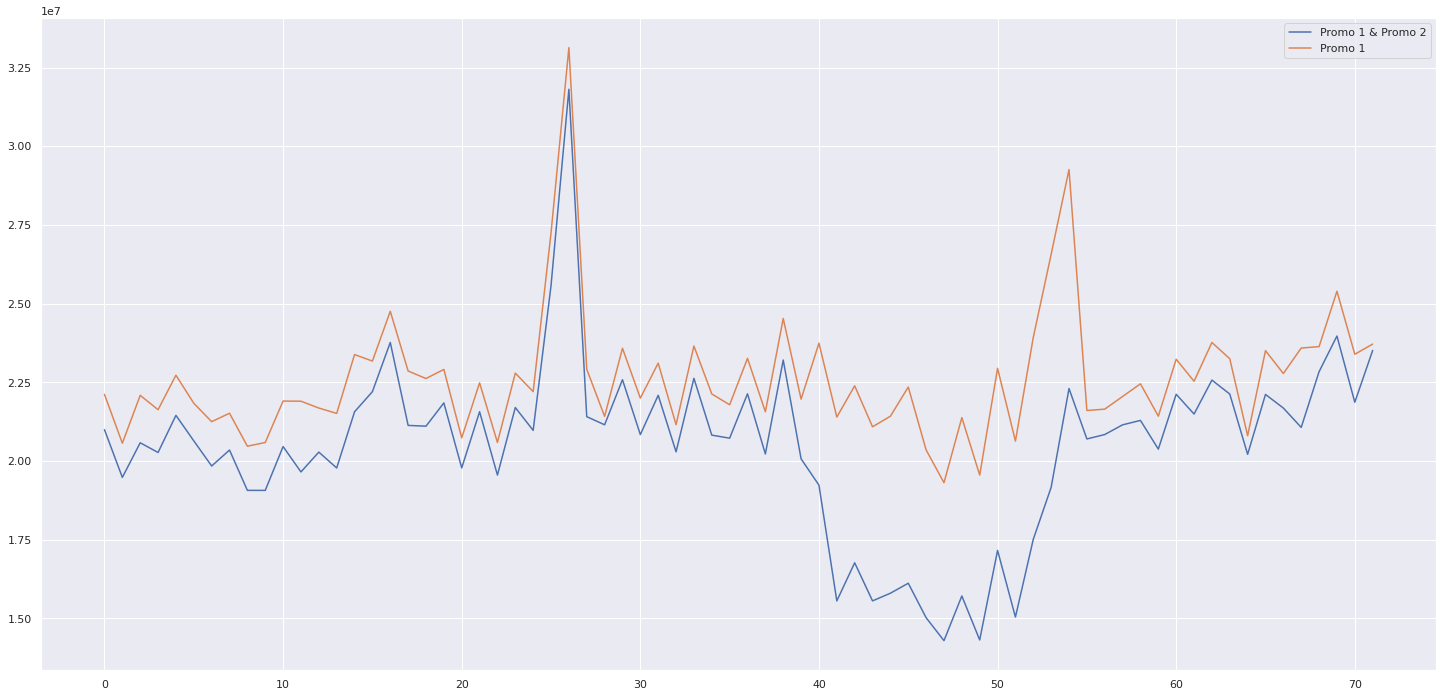

In [50]:
 aux425_1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux425_1.plot()

aux425_2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux425_2.plot( ax=ax )

ax.legend( labels=['Promo 1 & Promo 2', 'Promo 1']);

### 4.2.6 - H6 - Stores that open during christmas season should sell more.

**False:** Easter holidays sell better than christmas. Sorry santa, but Buny wins this one :(

In [71]:
df4.state_holiday.value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

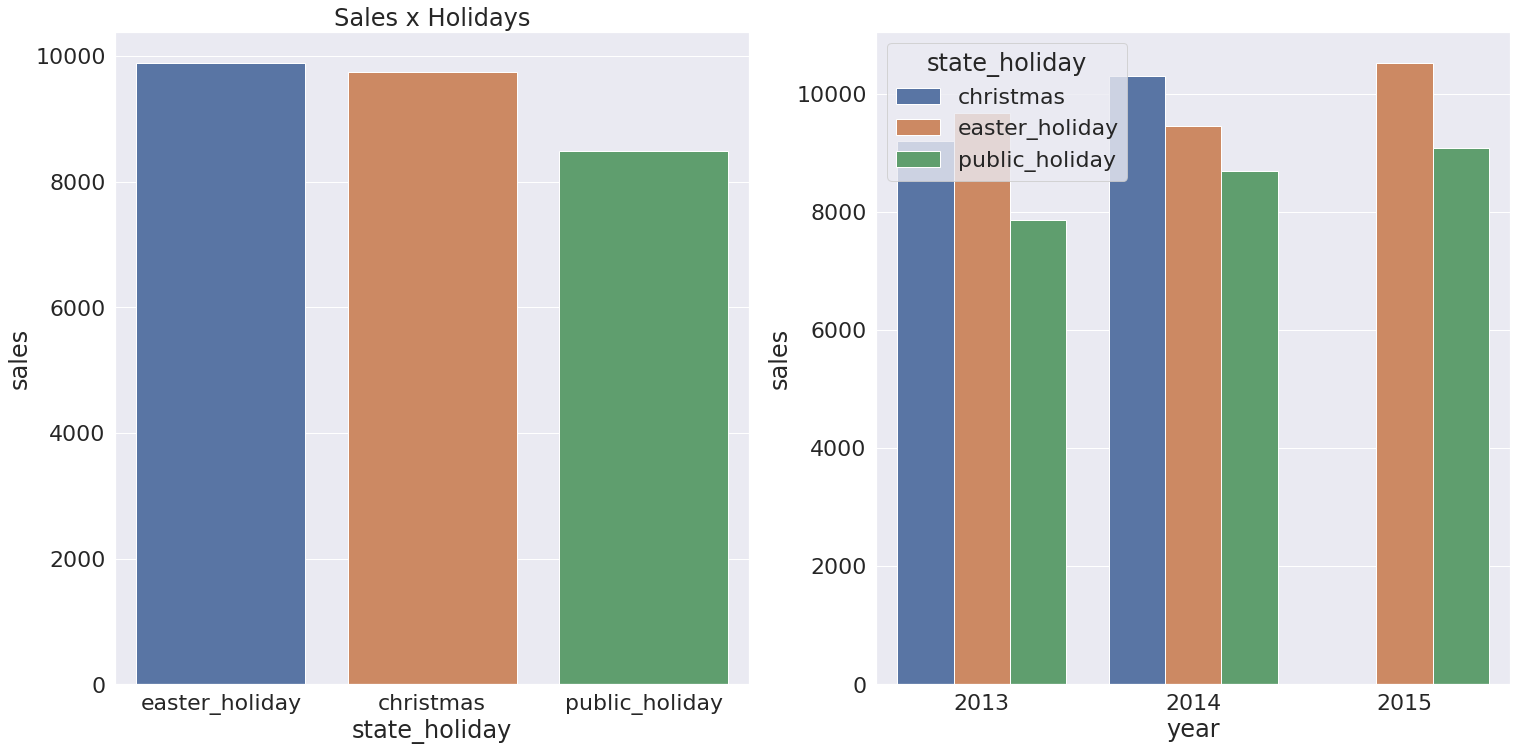

In [60]:
aux426_1 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux426_2 = aux426_1[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().sort_values(by='sales', ascending=False).reset_index()
#sns.set(font_scale=2)
g = sns.barplot( x='state_holiday', y='sales', data=aux426_2 ).set_title("Sales x Holidays").get_figure()
#g.savefig("/home/mvrcosp/repos/DSP/Rossmann/img/SalesHolidays.png")

plt.subplot( 1, 2, 2 )
aux426_3 = aux426_1[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux426_3 ); 

### 4.2.7 - H7 - Stores should sell more over the years.

**False:** Stores are selling less over the years.

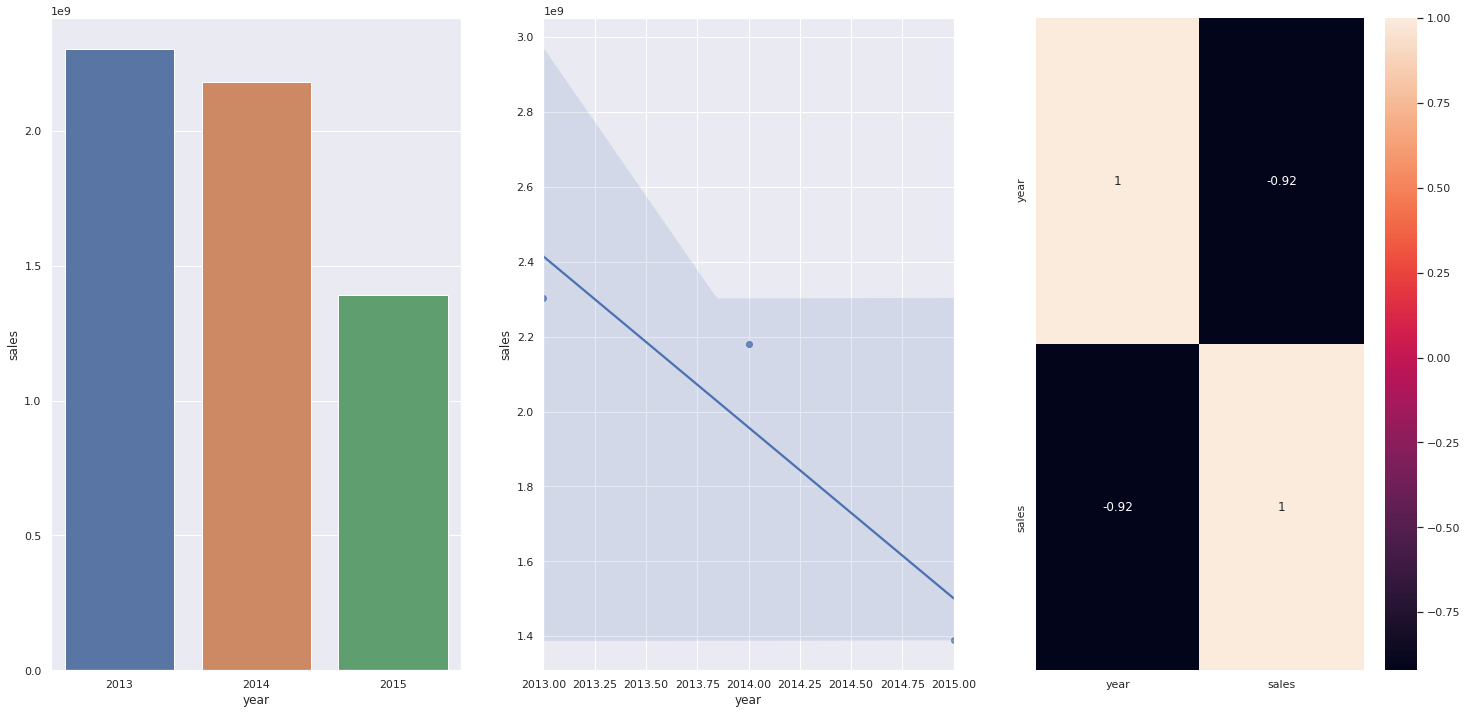

In [52]:
 aux427_1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux427_1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux427_1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux427_1.corr( method='pearson' ), annot=True );

### 4.2.8 - H8 - Stores should sell more at the 2nd semester of the year.

**False:** Stores sell more at first semester of the year.

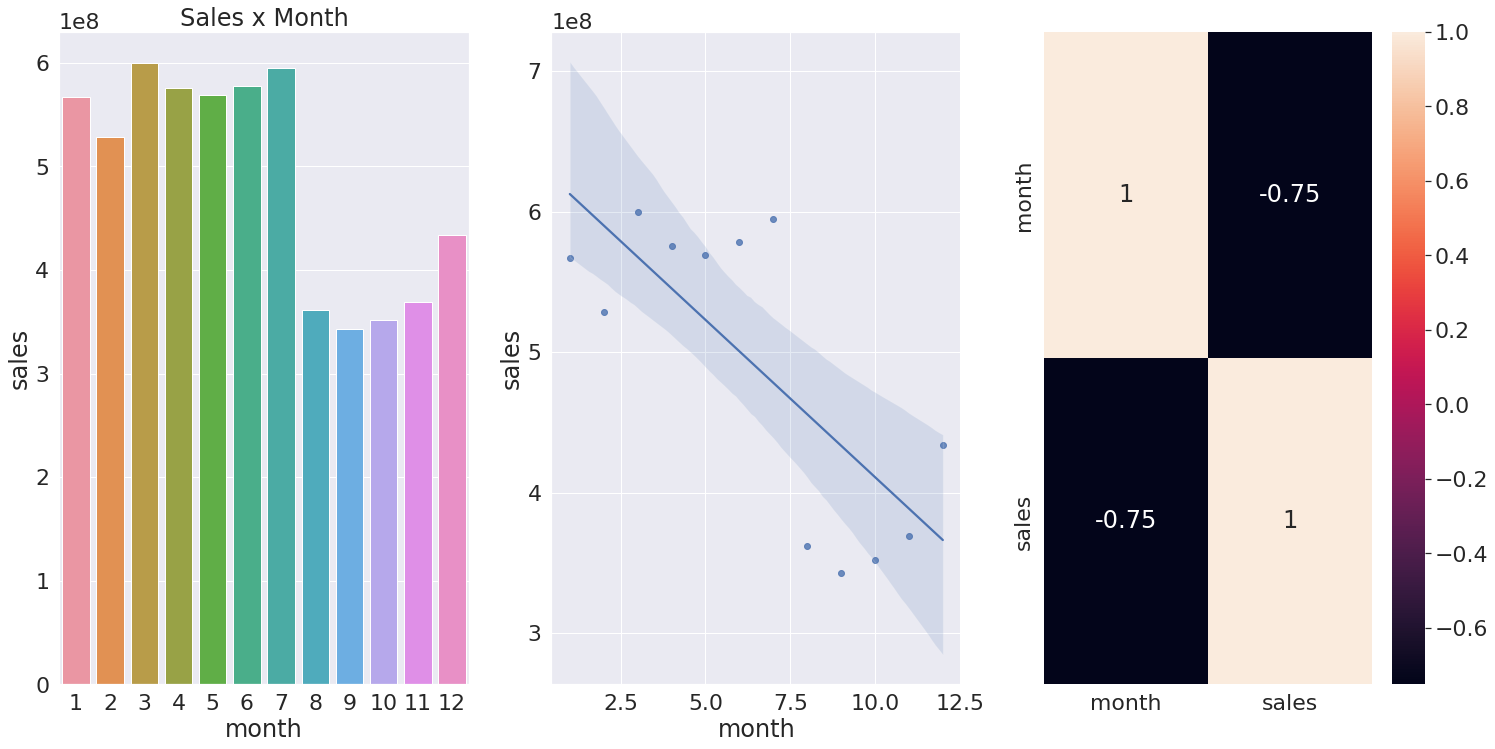

In [57]:
aux428_1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
#sns.set(font_scale=2)
g = sns.barplot(x='month', y='sales', data=aux428_1).set_title("Sales x Month").get_figure()
#g.savefig("/home/mvrcosp/repos/DSP/Rossmann/img/SalesThroughoutTheMonths.png")

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux428_1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux428_1.corr( method='pearson' ), annot=True );

### 4.2.9 - H9 - Stores should sell more at the beginning of each month.

**True:** Stores do sell a little bit more at the beginning of the month.

<AxesSubplot:xlabel='days_binned', ylabel='sales'>

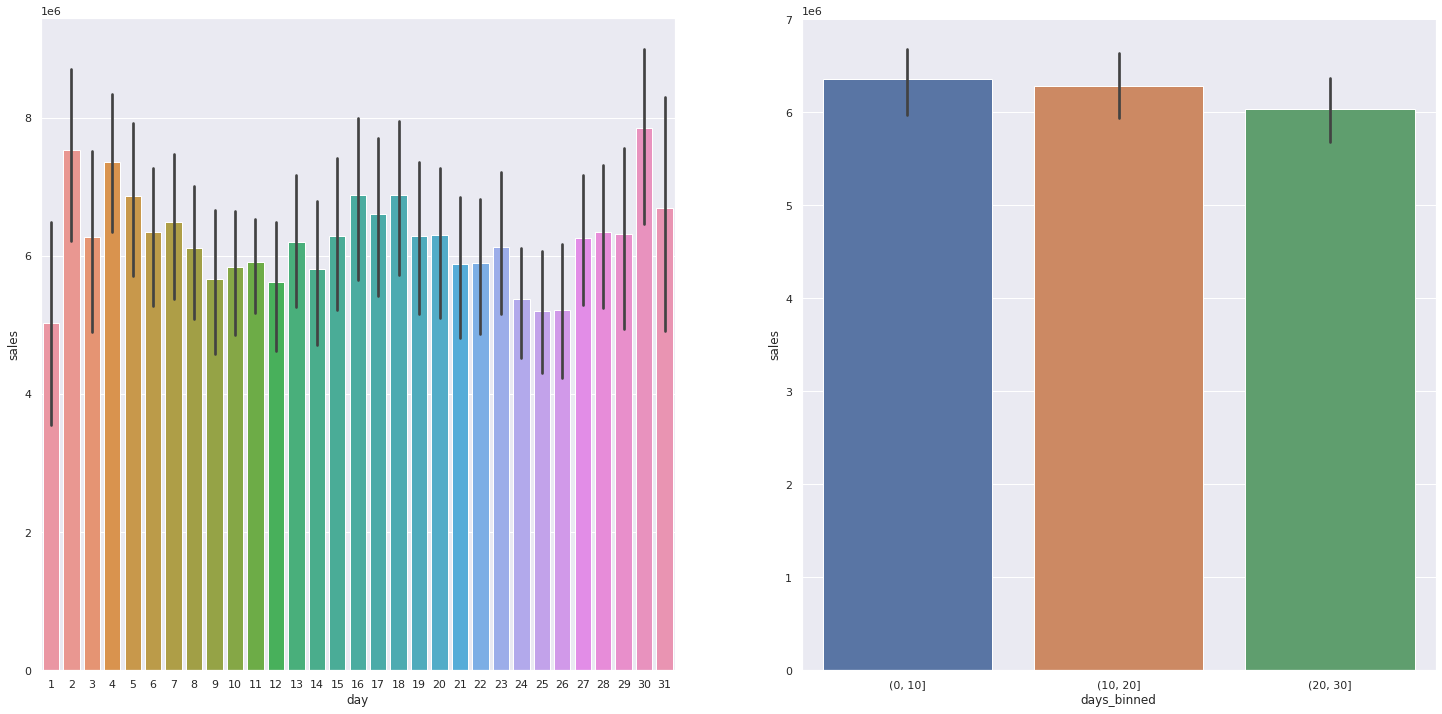

In [54]:
plt.subplot(1, 2, 1)
aux429_1 = df4[['year', 'month', 'day', 'sales']].groupby(['year', 'month', 'day']).sum().reset_index()
sns.barplot(x='day', y='sales', data=aux429_1)

plt.subplot(1, 2, 2)
bins = list(np.arange(0, 40, 10))
aux429_1['days_binned'] = pd.cut(aux429_1['day'], bins = bins)
sns.barplot(x='days_binned', y='sales', data=aux429_1)

### 4.2.10 - H10 - Stores should sell less on weekends.

**True:** Stores DO sell less on weekends compared to weekdays.

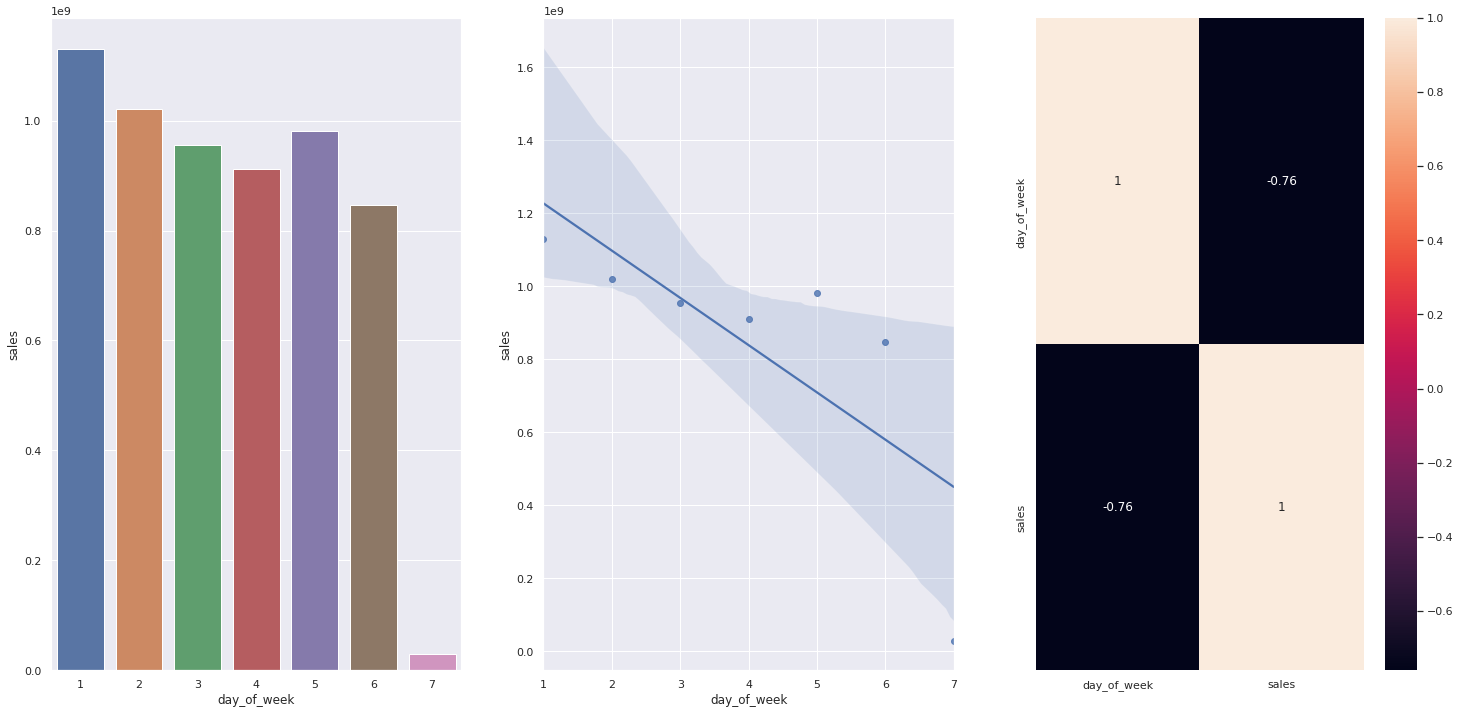

In [55]:
aux4210_1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux4210_1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux4210_1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux4210_1.corr( method='pearson' ), annot=True );

### 4.2.11 - H11 - Stores should sell less on school holidays.

**True:** Stores do sell less on school holidays. August is the only month where school holidays actually sell more.

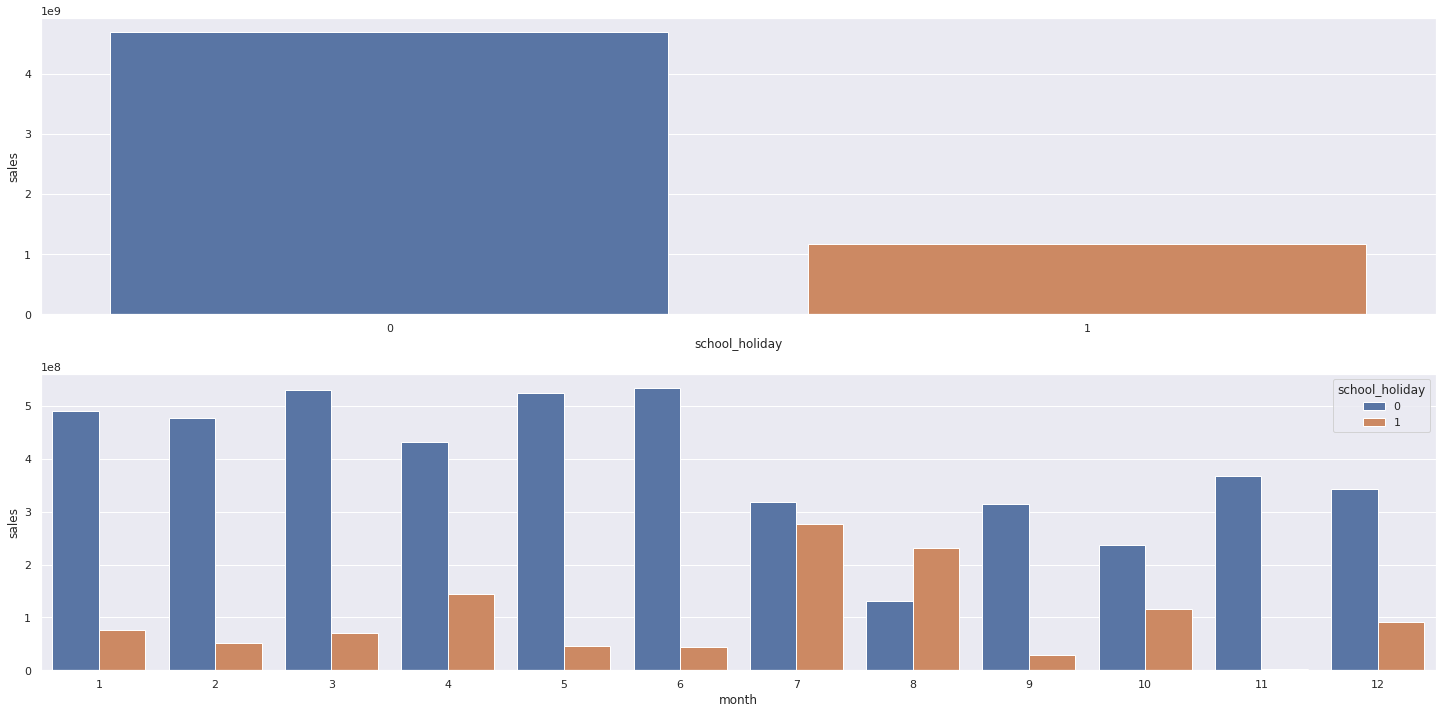

In [56]:
aux4211_1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux4211_1 );

aux4211_2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux4211_2 );

### 4.2.12 - Final Hypothesis table

In [57]:
from tabulate import tabulate

In [58]:
tab =[['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Low'],  
      ['H2', 'False', 'Medium'],  
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'Low'],
      ['H5', 'False', 'Low'],
      ['H6', 'False', 'Medium'],
      ['H7', 'False', 'High'],
      ['H8', 'True', 'High'],
      ['H9', 'True', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'Low']]  

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            False         Low
H6            False         Medium
H7            False         High
H8            True          High
H9            True          High
H10           True          High
H11           True          Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

<AxesSubplot:>

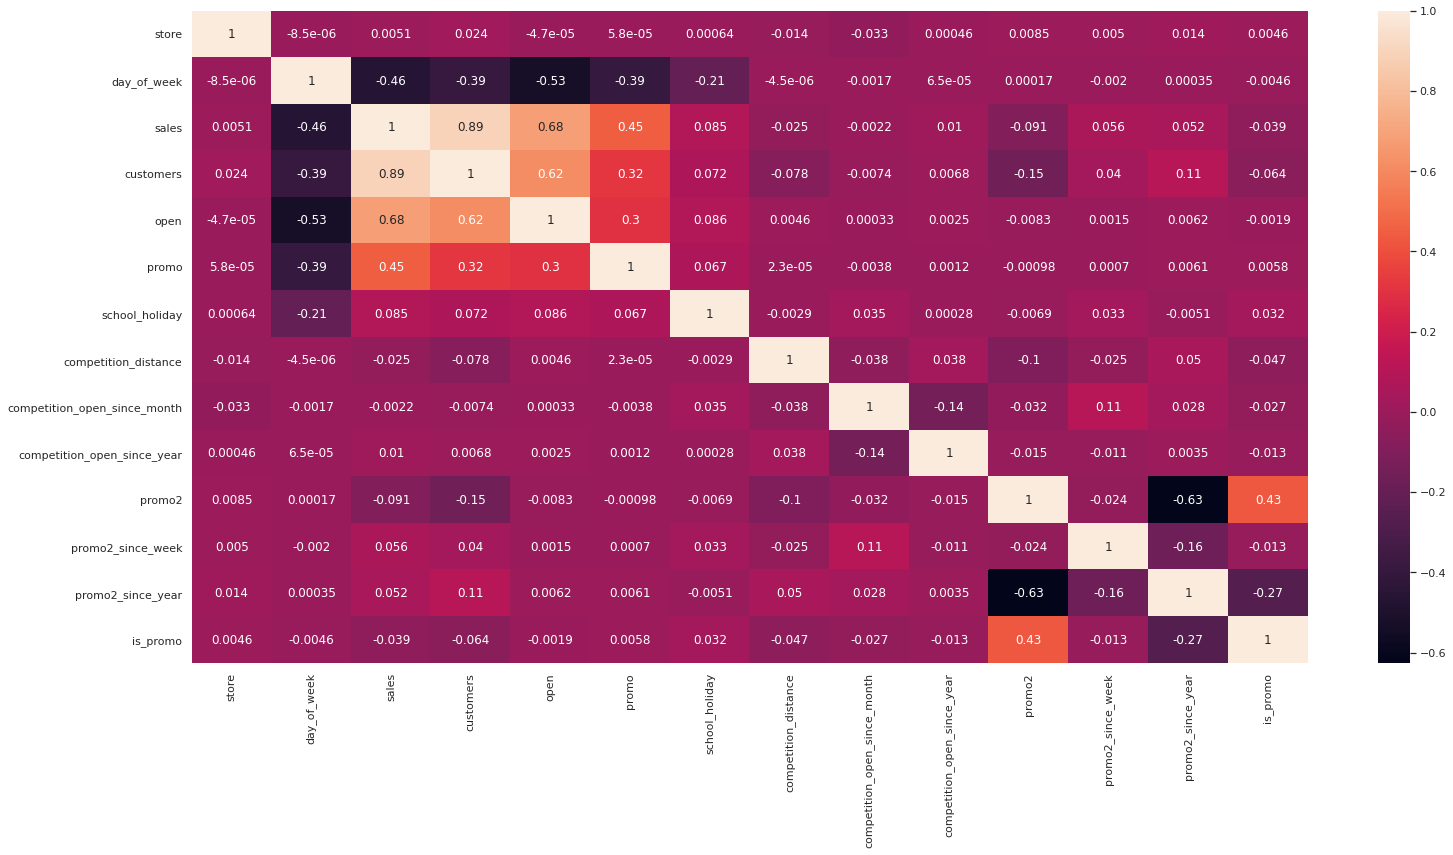

In [59]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorial Attributes

In [77]:
b = df4.select_dtypes('object')
b.drop('year_week', axis=1, inplace=True)

/home/mvrcosp/miniconda3/envs/DataScience_Em_Producao/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:>

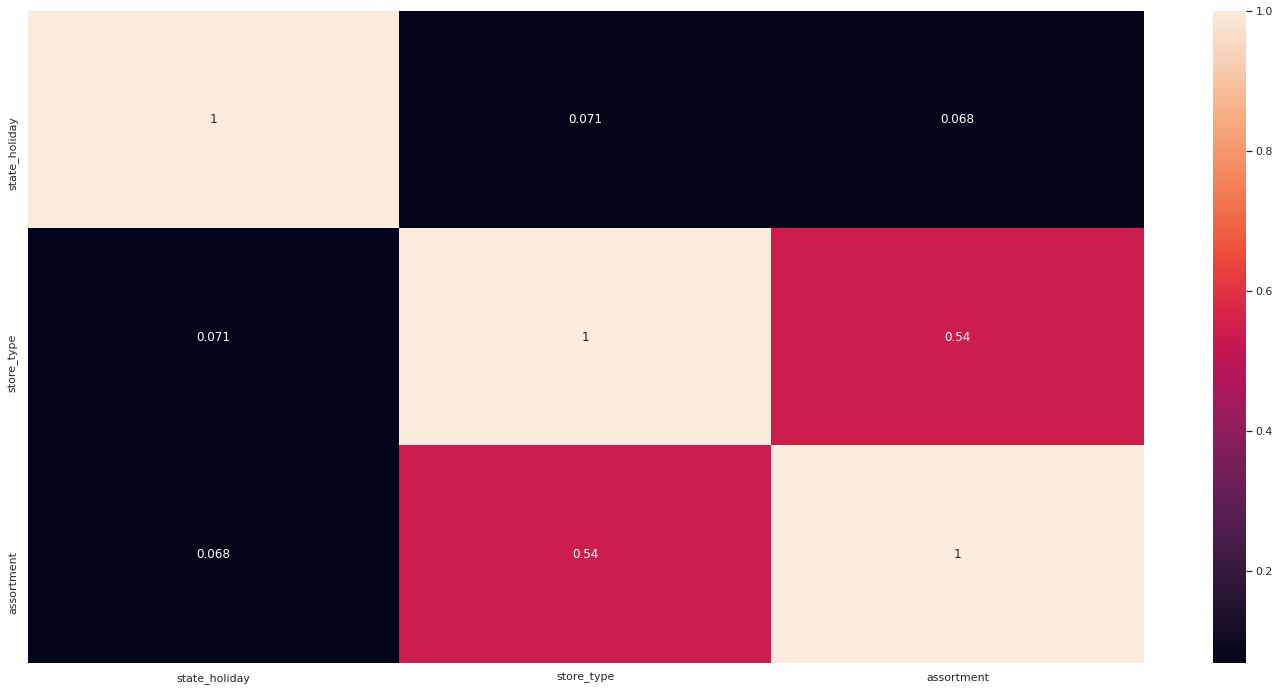

In [78]:
#Calculte Cramer V

b1 = cramer_v( b['state_holiday'], b['state_holiday'] )
b2 = cramer_v( b['state_holiday'], b['store_type'] )
b3 = cramer_v( b['state_holiday'], b['assortment'] )

b4 = cramer_v( b['store_type'], b['state_holiday'] )
b5 = cramer_v( b['store_type'], b['store_type'] )
b6 = cramer_v( b['store_type'], b['assortment'] )

b7 = cramer_v( b['assortment'], b['state_holiday'] )
b8 = cramer_v( b['assortment'], b['store_type'] )
b9 = cramer_v( b['assortment'], b['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [b1, b2, b3], 
               'store_type': [b4, b5, b6],
               'assortment': [b7, b8, b9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )